# Data loading

In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import os
import numpy as np
import scipy.io

In [3]:
data_path = "./pd.mat"
data_mat = scipy.io.loadmat(data_path)
data = data_mat["pds"]

print(f"Data shape: {data.shape}")

Data shape: (50, 7)


In [4]:
# y - labels - type of diagram [0-7]
# We transpose to iterate over diagram list
y = []
for label, diagram_list in enumerate(data.T):
    y += len(diagram_list) * [label]
y = np.array(y)

# data.T = 2d array of diagrams as row, column as type
X = data.T.reshape(-1)

# Model comparison

In [5]:
import joblib
import pandas as pd
import sklearn

from preprocessing import *
from persistent_bow import *
from visualization import *
from fisher_vector_transformer import *
from experiments.utils import *

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.mixture import GaussianMixture

from gudhi.representations.kernel_methods import SlicedWassersteinKernel
from gudhi.representations.vector_methods import PersistenceImage
from gudhi.representations.metrics import BottleneckDistance

#Fast hack to make SlicedWassersteinKernel scikit-compliant
setattr(SlicedWassersteinKernel, "get_params",
        lambda self, deep: {
            "bandwidth":self.bandwidth,
            "num_directions" : self.sw_.num_directions
        })

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
fold = StratifiedKFold(5, shuffle=True, random_state=42)
gridsearch_splits = np.array([split for split in fold.split(X_train, y_train)])

In [7]:
#Helper function, constructs final pipeline and returns girdsearch for it
def make_final_grid(estimator,
                    param_grid,
                    kernel="linear",
                    cv=gridsearch_splits,
                    **kwargs):
    new_param_grid = {f"Model__{name}" : values for name, values in param_grid.items()}
    new_param_grid["Predictor__C"] = [0.1, 1, 10]
    
    final_pipeline = Pipeline([
        ("Model", estimator),
        ("Predictor", SVC(kernel=kernel, max_iter=1e6))
    ])
    
    return GridSearchCV(final_pipeline, new_param_grid, cv = cv, **kwargs)

In [8]:
#PBoW gridsearch
pbow_gridsearch = make_final_grid(
    estimator = PersistentBow(KMeans(7, n_init=1, max_iter=100, random_state=42),
                              sampler=RandomPDSampler(2500, random_state=42)),
    param_grid = {
        "cluster__n_clusters" : np.arange(10, 150, 15),
        "sampler__max_points" : np.arange(1000, 10000, 2000),
        "sampler__weight_function" : [const, linear]
    },
    n_jobs = -1
)

#SPBoW gridsearch
spbow_gridsearch = make_final_grid(
    estimator = StablePersistentBow(GaussianMixture(covariance_type="diag", random_state=42),
                              sampler=RandomPDSampler(2500, random_state=42)),
    param_grid = {
        "mixture__n_components" : np.arange(10, 200, 15),
        "sampler__max_points" : np.arange(1000, 13000, 2000),
        "sampler__weight_function" : [const, linear]
    },
    n_jobs = -1
)

#PBoW gridsearch with grid sampler
pbow_grid_gridsearch = make_final_grid(
    estimator = PersistentBow(KMeans(7, n_init=1, max_iter=100, random_state=42),
                              sampler=GridPDSampler((10,10), 100, random_state=42)),
    param_grid = {
        "cluster__n_clusters" : np.arange(10, 150, 15),
        "sampler__max_points" : [10, 50, 100, 200, 500],
        "sampler__grid_shape" : [(5,5), (10,10), (15,15), (20,20), (40,40)],
        "sampler__weight_function" : [const, linear]
    },
    n_jobs = -1
)

#SPBoW gridsearch with grid sampler
spbow_grid_gridsearch = make_final_grid(
    estimator = StablePersistentBow(GaussianMixture(covariance_type="diag", random_state=42),
                              sampler=GridPDSampler((10,10),100, random_state=42)),
    param_grid = {
        "mixture__n_components" : np.arange(10, 200, 15),
        "sampler__max_points" : [10, 50, 100, 200, 500],
        "sampler__grid_shape" : [(5,5), (10,10), (15,15), (20,20), (40,40)],
        "sampler__weight_function" : [const, linear]
    },
    n_jobs = -1
)


#SlicedWassersteinKernel gridsearch (without using it as kernel)
swk_gridsearch = make_final_grid(
    estimator = SlicedWassersteinKernel(),
    param_grid = {
        "bandwidth" : [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2],
        "num_directions" : [5, 10, 15, 20, 25]
    },
    n_jobs = -1    
)

#SlicedWassersteinKernel gridsearch (using it as kernel)
swk_ker_gridsearch = make_final_grid(
    estimator = SlicedWassersteinKernel(),
    param_grid = {
        "bandwidth" : [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2],
        "num_directions" : [5, 10, 15, 20, 25]
    },
    kernel="precomputed",
    n_jobs = -1
)

#BottleneckDistance gridsearch
bd_gridsearch = make_final_grid(
    estimator = BottleneckDistance(),
    param_grid = {
        "epsilon" : [1e-8, None]
    },
    n_jobs = -1  
)

#PersistenceImage gridsearch
pi_gridsearch = make_final_grid(
    estimator = PersistenceImage(),
    param_grid = {
        "bandwidth" : [0.1, 0.25, 0.5, 1, 1.5],
        "weight" : [const, linear, pow2],
        "resolution" : [(10,10), (20,20), (40,40), (50, 50)],
    },
    n_jobs = -1
)

# Fisher_vector 
fisher_vector_gridsearch = make_final_grid(
    FisherVectorTransformer(sampler=RandomPDSampler(random_state=42)), 
    param_grid = {
        "gmm_clusters_number" : np.arange(10, 200, 15),
        "sampler__max_points" : np.arange(1000, 13000, 2000),
        "sampler__weight_function" : [const, linear]},
    n_jobs= - 1)

# Fisher_vector with grid sampler
fisher_vector_grid_gridsearch = make_final_grid(
    FisherVectorTransformer(sampler=GridPDSampler((10,10), 100,random_state=42)), 
    param_grid = {
        "gmm_clusters_number" : np.arange(10, 200, 15),
        "sampler__max_points" : [10, 50, 100, 200, 500],
        "sampler__grid_shape" : [(5,5), (10,10), (15,15), (20,20), (40,40)],
        "sampler__weight_function" : [const, linear]},
    n_jobs= - 1)

models_to_test = {
    "PBoW" : pbow_gridsearch, 
    "PBoW_Grid" : pbow_grid_gridsearch,
    "SPboW" : spbow_gridsearch,
    "SPBoW_Grid" : spbow_grid_gridsearch,
    "SWK" : swk_gridsearch, 
    "SWK_ker" : swk_ker_gridsearch,
    "Bottleneck" : bd_gridsearch,
    "PersistenceImage" : pi_gridsearch,
    "FisherVector": fisher_vector_gridsearch,
    "FisherVector_Grid": fisher_vector_grid_gridsearch
}

In [9]:
#Hyperparameter optimization
for name, grid in models_to_test.items():
    print(name)
    grid_path = f"precomputed/grid/{name}.dill"
    
    out = load(grid_path)
    if out:
        print("Loaded from file")
        models_to_test[name] = out
    else:
        grid.verbose = 10
        grid.fit(X_train, y_train)
        save(grid, grid_path)

PBoW
Loaded from file
PBoW_Grid
Loaded from file
SPboW
Loaded from file
SPBoW_Grid
Loaded from file
SWK
Loaded from file
SWK_ker
Loaded from file
Bottleneck
Loaded from file
PersistenceImage
Loaded from file
FisherVector
Loaded from file
FisherVector_Grid
Loaded from file


## Comparison of best estimators

In [10]:
#Score calculation
grid_path = "precomputed/grid"
cv_path = "precomputed/cv"

for filename in os.listdir(grid_path):
    name = os.path.splitext(filename)[0]
    grid = load(os.path.join(grid_path, filename))
    results = load(os.path.join(cv_path, filename))
    
    if not results:
        print("Computing", name)
        model = grid.best_estimator_
        model.fit(X_train, y_train)
        results = model.score(X_test, y_test)
        save(results, os.path.join(cv_path, f"{name}.dill"))

In [11]:
#Printing scores
base_path = "precomputed/cv"
for filename in os.listdir(base_path):
    path = os.path.join(base_path, filename)
    name = os.path.splitext(filename)[0]
    
    result = load(path)
    print(name, "Test set score:\n", result, "\n")

SWK_ker Test set score:
 0.9857142857142858 

PBoW_Grid Test set score:
 0.9428571428571428 

SPboW Test set score:
 0.9714285714285714 

PersistenceImage Test set score:
 0.9571428571428572 

SPBoW_Grid Test set score:
 0.9857142857142858 

PBoW Test set score:
 0.9571428571428572 

Bottleneck Test set score:
 0.7142857142857143 

SWK Test set score:
 0.9857142857142858 

FisherVector Test set score:
 0.8571428571428571 

FisherVector_Grid Test set score:
 0.9285714285714286 



## Listing  of best parameters for each model

In [12]:
for name, grid in models_to_test.items():
    print(name, "Best parameters:")
    grid_params = grid.best_params_
    for param_name, value in grid_params.items():
        print(f'{param_name} : {value}')
    print()

PBoW Best parameters:
Model__cluster__n_clusters : 70
Model__sampler__max_points : 1000
Model__sampler__weight_function : <function linear at 0x7f04078559e0>
Predictor__C : 0.1

PBoW_Grid Best parameters:
Model__cluster__n_clusters : 115
Model__sampler__grid_shape : (20, 20)
Model__sampler__max_points : 10
Model__sampler__weight_function : <function const at 0x7f0407855950>
Predictor__C : 1

SPboW Best parameters:
Model__mixture__n_components : 85
Model__sampler__max_points : 3000
Model__sampler__weight_function : <function const at 0x7f0407855950>
Predictor__C : 10

SPBoW_Grid Best parameters:
Model__mixture__n_components : 25
Model__sampler__grid_shape : (10, 10)
Model__sampler__max_points : 500
Model__sampler__weight_function : <function linear at 0x7f04078559e0>
Predictor__C : 10

SWK Best parameters:
Model__bandwidth : 0.1
Model__num_directions : 5
Predictor__C : 1

SWK_ker Best parameters:
Model__bandwidth : 1
Model__num_directions : 5
Predictor__C : 10

Bottleneck Best parameter

## Plot - PBoW accuracy vs n_clusters

Plotting for n_clusters: 10 25 40 55 70 85 100 115 130 145 

Text(0.5, 1.0, 'Accuracy on test set vs number of components')

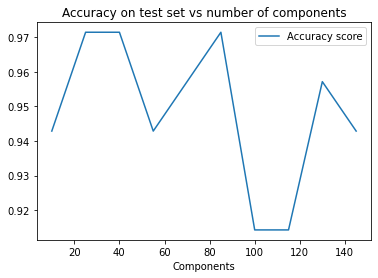

In [13]:
best_estimator = models_to_test["PBoW"].best_estimator_
n_clusters_range = models_to_test["PBoW"].param_grid["Model__cluster__n_clusters"]

result_list = []
print("Plotting for n_clusters:", end=" ")
for n_clusters in n_clusters_range:
    estimator = sklearn.base.clone(best_estimator)
    print(n_clusters, end = " ")
    estimator.set_params(Model__cluster__n_clusters=n_clusters)
    estimator.fit(X_train, y_train)
    results = estimator.score(X_test, y_test)
    result_list.append(results)
    
plt.plot(n_clusters_range, result_list, label="Accuracy score")
plt.xlabel("Components")
plt.legend()
plt.title("Accuracy on test set vs number of components")

## Plot - PBoW accuracy vs sampler max_points

Plotting for points:  1000 3000 5000 7000 9000 

Text(0.5, 1.0, 'Accuracy on test set vs max_points')

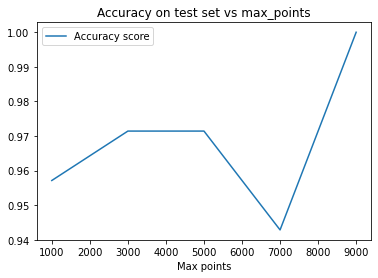

In [14]:
best_estimator = models_to_test["PBoW"].best_estimator_
max_points_range = models_to_test["PBoW"].param_grid["Model__sampler__max_points"]

print("Plotting for points: ", end=" ")

result_list = []
for max_points in max_points_range:
    estimator = sklearn.base.clone(best_estimator)
    print(max_points, end = " ")
    estimator = estimator.set_params(Model__sampler__max_points=max_points)
    estimator.fit(X_train, y_train)
    results = estimator.score(X_test, y_test)
    result_list.append(results)
    
plt.plot(max_points_range, result_list, label="Accuracy score")
plt.xlabel("Max points")
plt.legend()
plt.title("Accuracy on test set vs max_points")